# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode
import package_Heni_Matthias
from package_Heni_Matthias import LL_RT, PID_RT, Regulator, IMC_Tuning, FF_RT, Bode_Regulator, margins

# Paramètres

In [2]:
TSim = 4000
Ts = 1
N = int(TSim / Ts) + 1

# DV MV PV 
DV0 = 50
MV0 = 50
PV0 = 60


# paramètres de P(s) 2eme ordre pouvant être considérer comme premier ordre 

Kp = 0.5707425748689002
T1p = 196.07639597042842
T2p= 0.00019390337258466675
thetap=5.404503767391171

# paramètres de D(s) 2ème ordre 
Kd = 0.353510093903356
T1d= 191.4325387239411
T2d= 152.59044478168957
thetad = 1.8616011374729724

#rapport des gains 
KFF = -Kd/Kp

gamma = 0.9
#limites
MV_MIN = 0
MV_MAX = 100

In [3]:
Kc,T_I,T_D,alpha = IMC_Tuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')
print("alpha", alpha)
#alpha = 20
print("gama", gamma)

alpha 0.25
gama 0.9


# initialisation paramètres

In [4]:
t = []
SP = []
DV = []
PV = []
E = []
MV = []
MV_P = []
MV_I = []
MV_D = []
MAN = []
MV_MAN = []

MVFFDelay = []
MVFFLL1 = []
MV_FF = []

PV_LL1 = []
PV_LL2 = []

MVDelayp = []
PV1p = []
PV2p = []

MVDelayd = []
PV1d = []
PV2d = []


# Mode automatique manuel avec et sans FF

In [5]:
# Closed loop response to a SP change
ManPath = {0: False, TSim: False}
MVManPath = {0: MV0, TSim: MV0}
SPPath = {0: PV0, 850: PV0 + 10, TSim: PV0 + 10}
DVPath = {0: DV0, 1000: DV0 + 20 , TSim: DV0 + 20}
activateFF= False
# ManFF = False

# Response to DV : No FF and controller in manual mode
# ManPath = {0: False, 1: True, TSim: True}
# MVManPath = {0: MV0, TSim: MV0}
# SPPath = {0: PV0, 850: PV0, TSim: PV0}
# DVPath = {0: DV0, 1000: DV0 + 20, TSim: DV0 + 20}
# FF = False
# ManFF = True

# Response to DV : FF and controller in manual mode
# ManPath = {0: False, 1: True, TSim: True}
# MVManPath = {0: MV0, TSim: MV0}
# SPPath = {0: PV0, 850: PV0, TSim: PV0}
# DVPath = {0: DV0, 1000: DV0 + 20, TSim: DV0 + 20}
# FF = True
# ManFF = True

# Response to DV : No FF and controller in automatic mode
# ManPath = {0: False, TSim: True}
# MVManPath = {0: MV0, TSim: MV0}
# SPPath = {0: PV0, 850: PV0, TSim: PV0}
# DVPath = {0: DV0, 1000: DV0 + 20, TSim: DV0 + 20}
# FF = False
# ManFF = False

# Response to DV : FF and controller in automatic mode
#ManPath = {0: False, TSim: True}
#MVManPath = {0: MV0, TSim: MV0}
#SPPath = {0: PV0, 850: PV0, TSim: PV0}
#DVPath = {0: DV0, 1000: DV0 + 20, TSim: DV0 + 20}
#FF = True
#ManFF = False

# Simulation

In [6]:
for i in range(0,N):
    t.append(i*Ts)
    
    # SP et DV
    SelectPath_RT(SPPath, t, SP)
    SelectPath_RT(DVPath,t,DV)
    
   
    if activateFF:
        Delay_RT(DV - DV0 * np.ones_like(DV), np.max([thetad - thetap, 0]), Ts, MVFFDelay)
        LL_RT(MVFFDelay, KFF, T1p, T1d, Ts, MVFFLL1)
        LL_RT(MVFFLL1,1,T2p,T2d,Ts,PV_LL2)
    else:
        LL_RT(DV,0,T2p,T2d,Ts,PV_LL2,PVInit=0)
    
    #mode manuel
    SelectPath_RT(ManPath,t,MAN)
    SelectPath_RT(MVManPath,t,MV_MAN)
    
    #PID
    PID_RT(SP,PV,MAN,MV_MAN,MV_FF,Kc,T_I,T_D,alpha,Ts,MV_MAX,MV_MIN,MV,MV_P,MV_I,MV_D,E,False,0,method='EBD_EBD')
    
    
    #P(s)
    
    Delay_RT(MV,thetap,Ts,MVDelayp,MV0)
    FO_RT(MVDelayp,Kp,T1p,Ts,PV1p,0)
    FO_RT(PV1p,1,T2p,Ts,PV2p,0)
    
    #D(s)
    Delay_RT(DV-DV0*np.ones_like(DV),thetap,Ts,MVDelayd,0)
    FO_RT(MVDelayd,Kd,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)   
    
    PV.append(PV2p[-1]+PV2d[-1]+ (PV0-Kp*MV0) )
    

0


# Graph

(0.0, 4000.0)

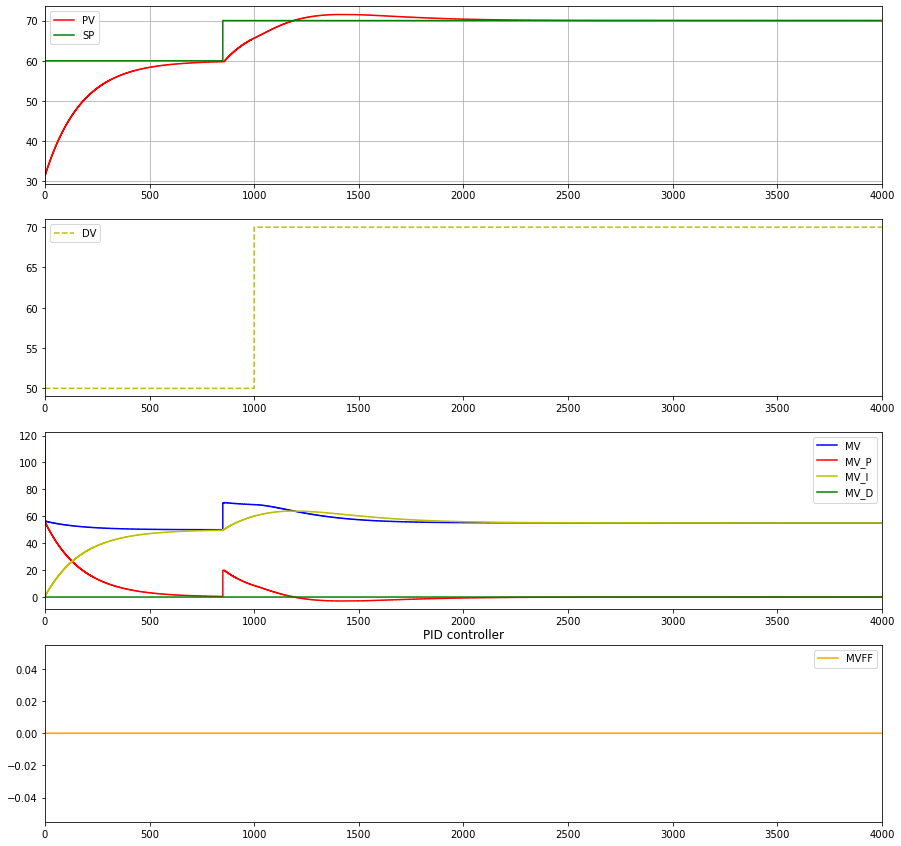

In [7]:
plt.figure(figsize = (15,15))
plt.subplot(4,1,1)
plt.step(t,PV,'r-', label = 'PV', where='post')
plt.step(t,SP,'g-', label = 'SP', where='post')
plt.grid()
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,2)
plt.step(t,DV,'y--', label = 'DV', where='post')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,3)
plt.step(t,MV,'b', label = 'MV', where='post')
plt.step(t,MV_P,'r-', label = 'MV_P', where='post')
plt.step(t,MV_I,'y-', label = 'MV_I', where='post')
plt.step(t,MV_D,'g-', label = 'MV_D', where='post')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,4)
plt.step(t,PV_LL2,'orange', label = 'MVFF', where='post')
plt.legend(loc='best')

#plt.ylabel('Value of MV')
plt.title('PID controller')
plt.legend(loc='best')
plt.xlim([0, TSim])
